In [151]:
import random
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np

import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image, ImageDraw, _imaging
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Embedding
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.merge import concatenate
from keras.utils import plot_model
from keras.models import Model
from keras import backend as K
from keras import metrics
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.model_selection import train_test_split
import tensorflow as tf
from datetime import datetime
from keras.callbacks import History, ModelCheckpoint
history = History()
from keras.models import model_from_json
import graphviz

In [172]:
def showSampleImgs():
    n_samp = 3
    train_df_sample = train_df.sample(n_samp)
    plt.figure(figsize=(4,4))
    for i in range(n_samp):
        draw = train_df_sample.iloc[i]['drawing']
        label = train_df_sample.iloc[i]['word']
        plt.subplot(n_samp,1,i+1)
        for stroke in draw:
            plt.plot(stroke[0], stroke[1], marker='.', color='black')
            plt.title(label)
            plt.axis('off')
    plt.show()    
    
# Show an image from the dataframe
def showImgFromDf(df, index):
    # Show an image
    plt.imshow(df.iloc[index]['img'],cmap='gray')
    plt.title(df.iloc[index]['word'])
    plt.show()
    
def top_3_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)


# def baseline_conv_model(num_filters, num_classes, img_height, img_width):
#     model = Sequential()
#     model.add(Conv2D(num_filters*1, (5,5), input_shape=(img_height,img_width,1), activation='relu')) 
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Dropout(0.2))
#     model.add(Conv2D(num_filters*2, (5,5), activation='relu')) 
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Dropout(0.2))
#     model.add(Conv2D(num_filters*4, (3,3), activation='relu')) 
# #     model.add(MaxPooling2D(pool_size=(2,2)))
# #     model.add(Conv2D(num_filters*8, (3,3), activation='relu')) 
#     model.add(Dropout(0.2))
#     model.add(Flatten())
# #     model.add(Dense(2500, activation='relu'))
# #     model.add(Dropout(0.2))
#     model.add(Dense(2000, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(1500, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(1000, activation='relu'))
#     model.add(Dropout(0.2))
#     # model.add(Dense(num_classes, activation='softmax'))
#     # model.add(Activation('softmax'))
#     model.add(Dense(units=num_classes))
#     model.add(Activation(tf.nn.softmax))

#     # Compile
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', top_3_accuracy, 'categorical_crossentropy'])
#     return model

def baseline_conv_model_functional_API(num_filters, num_classes, img_height, img_width):
    # Input Layer
    inputLayerImg = Input(shape=(img_height,img_width,1))
    
    conv1 = Conv2D(num_filters*1, (5,5), activation='relu')(inputLayerImg)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    dropout1 = Dropout(0.2)(pool1)
    
    conv2 = Conv2D(num_filters*2, (5,5), activation='relu')(dropout1)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    dropout2 = Dropout(0.2)(pool2)
    
    conv3 = Conv2D(num_filters*4, (3,3), activation='relu')(dropout2)
    dropout3 = Dropout(0.2)(conv3)
    
    flat = Flatten()(dropout3)
    
    # Add the other scalar inputs as another data stream
    # Continuous variables
    inputLayerScalars = Input(shape=(1,))
    
    # Categorical variables
    # Define the embedding input
    inputLayer_Country = Input(shape=(1,)) 
    countryEmbeddingsLength = 7
#     # Let’s define the embedding layer and flatten it
    countryEmbeddings = Embedding(input_dim=(len(countryList)+1), output_dim=countryEmbeddingsLength, input_length=1)(inputLayer_Country)
    countryEmbeddings = keras.layers.Reshape((countryEmbeddingsLength,))(countryEmbeddings)
    
    # Merge the CNN flat layer and the other input layer
    mergedInput = concatenate([flat, inputLayerScalars, countryEmbeddings])
    
    dense1 = Dense(2000, activation='relu')(mergedInput)
    drop_dense1 = Dropout(0.2)(dense1)
    
    dense2 = Dense(1500, activation='relu')(drop_dense1)
    drop_dense2 = Dropout(0.2)(dense2)
    
    dense3 = Dense(1000, activation='relu')(drop_dense2)
    drop_dense3 = Dropout(0.2)(dense3)
    
    outputLayer = Dense(num_classes, activation=tf.nn.softmax)(drop_dense3)
    
    model = Model(inputs=[inputLayerImg, inputLayerScalars, inputLayer_Country], outputs=outputLayer)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', top_3_accuracy, 'categorical_crossentropy'])
    return model


In [3]:
random.seed(111)

# Generate class mappings
fnames = glob('train_simplified/*.csv')
tempDf = pd.DataFrame(columns=pd.read_csv(fnames[0], nrows=1).columns)

for name in fnames:
    data = pd.read_csv(name, nrows=2)
    tempDf = tempDf.append(data)
    
ys = tempDf['word']
    
# Convert class labels from categorical to numerical
unique_classes_list = ys.unique()
map_class_to_numeric = {k: v for v, k in enumerate(unique_classes_list)}
map_numeric_to_class = {v: k for k, v in map_class_to_numeric.iteritems()}

countryList = '''['BD','BE','BF','BG','BA','NotAvlbl','BM','BN','BO','JP','BI','BJ','BT','JM','JO','WS','BR','CR','JE','BY','BZ','RU','RW','BB','RS','TL','RE','TM','LR','RO','GU','GT','GR','GP','BH','GY','GG','GF','GE','GD','GB','GA','GN','GM','GL','GI','GH','OM','TN','BU','BW','HR','BS','HT','HU','HK','HN','AD','PR','PS','PW','PT','KN','PY','AI','PA','PF','PG','PE','PK','PH','PL','PM','ZM','EE','EG','ZA','EC','AL','AO','ZZ','ET','ZW','KY','ES','ME','MD','MG','MF','MA','MC','UZ','MM','ML','MO','MN','MH','US','MU','MT','MW','MV','MQ','MP','MS','MR','IM','UG','TZ','MY','MX','IL','FR','SJ','FI','FJ','FM','FO','NI','NL','NO','SO','VU','NC','NF','NG','NZ','NP','CI','CH','CO','CN','CM','CL','CA','CG','CF','OTHER','CD','CZ','CY','CX','UY','CW','CV','SZ','SX','KG','KE','SS','SR','KH','SV','ST','SK','KR','SI','KW','SN','SM','SC','KZ','SA','SG','SE','DO','DM','DJ','DK','VG','DE','YE','DZ','MK','YT','LB','LC','LA','TW','TT','TR','LK','LI','LV','TO','LT','LU','TJ','LS','TH','TG','TC','LY','VC','AE','VE','AG','AF','IQ','VI','IS','IR','AM','IT','VN','AN','AS','AR','AU','AT','AW','IN','AX','AZ','IE','ID','UA','QA','MZ']'''
countryList = eval(countryList)

In [142]:
countryIntMap = {value: int_value+1 for int_value, value in enumerate(countryList)}
# for x,y in enumerate(countryList): 
#     print(y)

In [148]:
# np.array(data['countrycode'].map(countryIntMap)).astype('int32')

In [ ]:
############################### GET NEW FEATURES

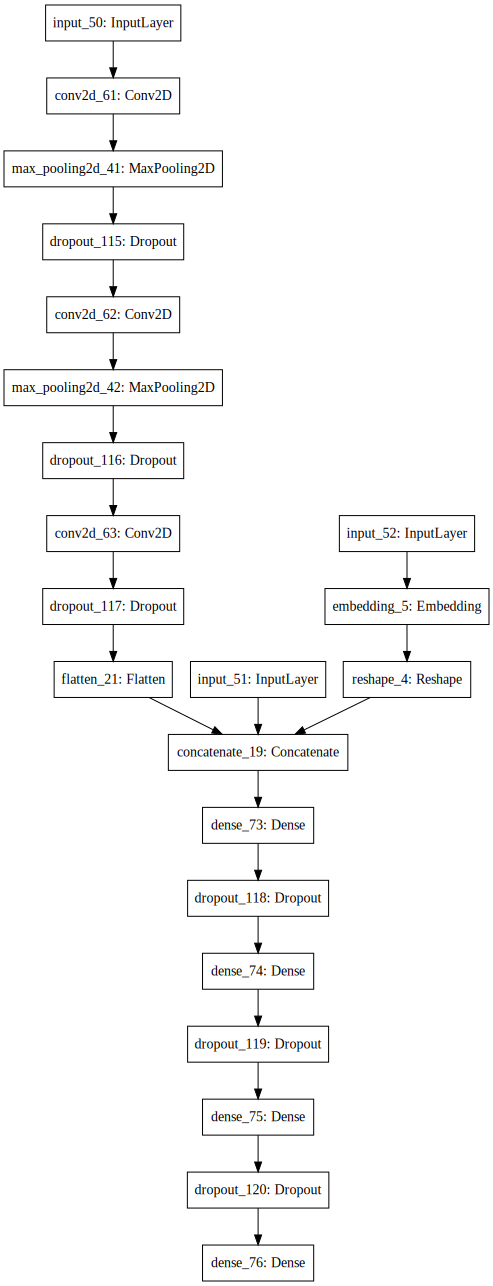

In [179]:
# model = baseline_conv_model_functional_API(numStartFilters, numClasses, img_height, img_width)
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [124]:
# model.summary()

In [ ]:
############################### GET NEW FEATURES

In [187]:
def draw_it(raw_strokes, output_height, output_width):
#     raw_strokes = eval(raw_strokes)
    image = Image.new("P", (255,255)
#                       , color=1
            )
    image_draw = ImageDraw.Draw(image)

    for stroke in raw_strokes:
        for i in range(len(stroke[0])-1):

            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=255, width=6)
    # Reduce image size
    image = image.resize((output_height,output_width),Image.ANTIALIAS)
    
    return np.array(image)


class DataGenerator(keras.utils.Sequence):
    def __init__(self, num_samples_to_train, batch_size, trainGeneratorDataOffsetPerClass, img_width, img_height):
        self.batch_size = batch_size
        self.num_samples_to_train = num_samples_to_train
        self.img_width = img_width
        self.img_height = img_height
        self.trainGeneratorDataOffsetPerClass = trainGeneratorDataOffsetPerClass
    
    def __len__(self):
        return np.ceil(self.num_samples_to_train / float(self.batch_size))
    
    def __getitem__(self, idx):
        
        numRowsEachDf = int(self.batch_size / float(numClasses))
        skipRows = (idx * numRowsEachDf) + self.trainGeneratorDataOffsetPerClass
        img_height = self.img_height 
        img_width = self.img_width
        
        X, y = DataGenerator._getNextData(numRowsEachDf, skipRows, img_height, img_width)
        
        return X, y
    
    @staticmethod
    def _getNextData(numRowsEachDf, skipRows, img_height, img_width):
        
        fnames = glob('train_simplified/*.csv')
        numClasses = len(fnames)

        # Get n rows from all the csv files and append them into one dataframe
        train_df = pd.DataFrame(columns=pd.read_csv(fnames[0], nrows=1).columns)
        
        for name in fnames:
            if skipRows == 0:
                data = pd.read_csv(name, nrows=numRowsEachDf)
            else:
                data = pd.read_csv(name, nrows=numRowsEachDf, skiprows=range(1,skipRows)) # 0th row is the header, so not skipping that
            # Append the training data of all the classes
            train_df = train_df.append(data)
            
        train_df = train_df.reset_index().drop('index', axis=1)
        
        # Some data manipulations
        train_df['countrycode'] = train_df['countrycode'].fillna('NotAvlbl')

        # Shuffle all data points
        train_df = train_df.sample(train_df.shape[0])

        # Get only those which were correctly recognized
        train_df = train_df[train_df['recognized'] == True]

        # Apply eval to drawing object
        train_df['drawing'] = train_df['drawing'].apply(eval)
        
        # Other features from the drawing array
        numStrokes = train_df['drawing'].apply(len)
        
        # Convert drawing to images
        train_df['drawing'] = train_df['drawing'].apply(lambda x: draw_it(x, img_height, img_width))

        # Reshape the array
        train_imgArr = np.vstack(train_df['drawing'].values).flatten().reshape((train_df['drawing'].shape[0], img_height, img_width))
    
        # In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [width][height][pixels] for TF.
        # In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In this case, the pixel values are gray scale, the pixel dimension is set to 1.
        train_X = train_imgArr.reshape(train_imgArr.shape[0], img_height, img_width, 1).astype('float32')
        
        
         # Initialize the y_train
        y_train = train_df['word']
    
        y_train_numeric = y_train.apply(lambda x: map_class_to_numeric[x])

        # convert class vectors to binary class matrices
        train_y = keras.utils.to_categorical(y_train_numeric, numClasses)
    
        # Get other features
        # Convert numStrokes into numpy array for ingestion [TODO: normalize]
        numStrokes = np.array(numStrokes).astype('float32')
        train_X_scalars = numStrokes
        
        train_X_countryInt = np.array(train_df['countrycode'].map(countryIntMap)).astype('int32')
        
        return [train_X, train_X_scalars, train_X_countryInt], train_y
    

In [175]:
img_width = img_height = 32

In [188]:
X_test, y_test = DataGenerator._getNextData(100, 90000, img_height, img_width)

In [189]:
# pp = []
batch_size = 1000
numTrainExamplesPerClass = 500
numClasses = 340
num_samples_to_train = (numTrainExamplesPerClass*numClasses)
trainGeneratorDataOffsetPerClass = 0
dataGenerator = DataGenerator(num_samples_to_train, batch_size, trainGeneratorDataOffsetPerClass, img_width, img_height)

In [190]:
# ############## Remove
# img_width = img_height = 32
# numClasses = 340
# numStartFilters = 8
# model = baseline_conv_model_functional_API(numStartFilters, numClasses, img_height, img_width)
# ############## Remove
# model.summary()

In [192]:
# model = baseline_conv_model(4, 340, 32, 32)
numStartFilters = 8
model = baseline_conv_model_functional_API(numStartFilters, numClasses, img_height, img_width)
model.fit_generator(
        generator=dataGenerator,
        epochs=100,
        verbose=1,
        shuffle=False,
        validation_data=(X_test, y_test)
    
#         ,
#         use_multiprocessing=True,
)
#       steps_per_epoch=(num_training_samples // batch_size),
#       validation_data=my_validation_batch_generator,
#       validation_steps=(num_validation_samples // batch_size),
#       use_multiprocessing=False,
#       workers=16,
#       max_queue_size=32)


Epoch 1/100
170/170 [==============================] - 950s 6s/step - loss: 6.2977 - acc: 0.0148 - top_3_accuracy: 0.0372 - categorical_crossentropy: 6.2977 - val_loss: 4.9736 - val_acc: 0.0479 - val_top_3_accuracy: 0.1115 - val_categorical_crossentropy: 4.9736
Epoch 2/100
170/170 [==============================] - 1323s 8s/step - loss: 4.8067 - acc: 0.0547 - top_3_accuracy: 0.1268 - categorical_crossentropy: 4.8067 - val_loss: 4.4304 - val_acc: 0.1070 - val_top_3_accuracy: 0.2218 - val_categorical_crossentropy: 4.4304
Epoch 3/100
170/170 [==============================] - 1143s 7s/step - loss: 4.3884 - acc: 0.0973 - top_3_accuracy: 0.2062 - categorical_crossentropy: 4.3884 - val_loss: 4.0042 - val_acc: 0.1615 - val_top_3_accuracy: 0.3078 - val_categorical_crossentropy: 4.0042
Epoch 4/100
170/170 [==============================] - 1082s 6s/step - loss: 4.0490 - acc: 0.1366 - top_3_accuracy: 0.2719 - categorical_crossentropy: 4.0490 - val_loss: 3.6571 - val_acc: 0.2073 - val_top_3_accur

170/170 [==============================] - 1159s 7s/step - loss: 2.2276 - acc: 0.4201 - top_3_accuracy: 0.6507 - categorical_crossentropy: 2.2276 - val_loss: 2.4385 - val_acc: 0.4144 - val_top_3_accuracy: 0.6294 - val_categorical_crossentropy: 2.4385
Epoch 33/100
170/170 [==============================] - 1093s 6s/step - loss: 2.2026 - acc: 0.4232 - top_3_accuracy: 0.6537 - categorical_crossentropy: 2.2026 - val_loss: 2.4247 - val_acc: 0.4179 - val_top_3_accuracy: 0.6308 - val_categorical_crossentropy: 2.4247
Epoch 34/100
170/170 [==============================] - 1086s 6s/step - loss: 2.1932 - acc: 0.4276 - top_3_accuracy: 0.6574 - categorical_crossentropy: 2.1932 - val_loss: 2.4688 - val_acc: 0.4113 - val_top_3_accuracy: 0.6243 - val_categorical_crossentropy: 2.4688
Epoch 35/100
170/170 [==============================] - 1074s 6s/step - loss: 2.1868 - acc: 0.4266 - top_3_accuracy: 0.6589 - categorical_crossentropy: 2.1868 - val_loss: 2.4564 - val_acc: 0.4128 - val_top_3_accuracy: 0.6

170/170 [==============================] - 1398s 8s/step - loss: 1.8245 - acc: 0.5003 - top_3_accuracy: 0.7341 - categorical_crossentropy: 1.8245 - val_loss: 2.6015 - val_acc: 0.4070 - val_top_3_accuracy: 0.6158 - val_categorical_crossentropy: 2.6015
Epoch 64/100
170/170 [==============================] - 1363s 8s/step - loss: 1.8170 - acc: 0.5032 - top_3_accuracy: 0.7357 - categorical_crossentropy: 1.8170 - val_loss: 2.5542 - val_acc: 0.4095 - val_top_3_accuracy: 0.6209 - val_categorical_crossentropy: 2.5542
Epoch 65/100
170/170 [==============================] - 1361s 8s/step - loss: 1.7921 - acc: 0.5074 - top_3_accuracy: 0.7384 - categorical_crossentropy: 1.7921 - val_loss: 2.5850 - val_acc: 0.4069 - val_top_3_accuracy: 0.6175 - val_categorical_crossentropy: 2.5850
Epoch 66/100
170/170 [==============================] - 1383s 8s/step - loss: 1.7639 - acc: 0.5128 - top_3_accuracy: 0.7453 - categorical_crossentropy: 1.7639 - val_loss: 2.5645 - val_acc: 0.4119 - val_top_3_accuracy: 0.6

170/170 [==============================] - 842s 5s/step - loss: 1.6255 - acc: 0.5458 - top_3_accuracy: 0.7759 - categorical_crossentropy: 1.6255 - val_loss: 2.6903 - val_acc: 0.4068 - val_top_3_accuracy: 0.6128 - val_categorical_crossentropy: 2.6903
Epoch 95/100
170/170 [==============================] - 682s 4s/step - loss: 1.6094 - acc: 0.5523 - top_3_accuracy: 0.7787 - categorical_crossentropy: 1.6094 - val_loss: 2.6946 - val_acc: 0.4034 - val_top_3_accuracy: 0.6159 - val_categorical_crossentropy: 2.6946
Epoch 96/100
170/170 [==============================] - 658s 4s/step - loss: 1.6184 - acc: 0.5476 - top_3_accuracy: 0.7777 - categorical_crossentropy: 1.6184 - val_loss: 2.6678 - val_acc: 0.4083 - val_top_3_accuracy: 0.6185 - val_categorical_crossentropy: 2.6678
Epoch 97/100
170/170 [==============================] - 694s 4s/step - loss: 1.6011 - acc: 0.5519 - top_3_accuracy: 0.7791 - categorical_crossentropy: 1.6011 - val_loss: 2.6942 - val_acc: 0.4033 - val_top_3_accuracy: 0.6131 

In [10]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))
# model

CNN Error: 29.11%


In [17]:
# model = 0

In [132]:
# %%time
# # Transform data for CNN
# X_train, X_test, y_train, y_test, imgArr_test, map_class_to_numeric, map_numeric_to_class = CNN_dataPrep(train_df, img_height, img_width)

In [2]:
# num_filters = 2
# num_classes = 340
# continueTrain = False
# if continueTrain == False:
#     model = baseline_conv_model(num_filters, num_classes, img_height, img_width)

# # checkpoint
# filepath="Saved_Models/weights.best.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks = [checkpoint]

# print(model.summary())

# hist = model.fit(X_train, 
#           y_train, 
#           validation_data=(X_test, y_test),
#           epochs=2, 
#           batch_size=5, 
#           verbose=2,
#           callbacks = callbacks)

In [37]:
# Save the model
# serialize model to JSON
model_json = model.to_json()
with open(("Saved_Models/model_" + str(datetime.today())[:16].replace(" ", "_").replace(":","-") + ".json"), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(("Saved_Models/model_" + str(datetime.today())[:16].replace(" ", "_").replace(":","-") + ".h5"))
print("Saved model to disk")

Saved model to disk


In [25]:
# model = ""

In [24]:
# Load the model back
# load json and create model
json_file = open('Saved_Models/model_2018-11-21_02-44.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("Saved_Models/model_2018-11-21_02-44.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', top_3_accuracy, 'categorical_crossentropy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
model = loaded_model

Loaded model from disk


# Create Test Data Set

In [38]:
def getTestData(img_height, img_width):
        
        numClasses = 340

        test_df = pd.read_csv('test_simplified.csv')            

        # Convert drawing to images
        test_df['drawing'] = test_df['drawing'].apply(lambda x: draw_it(x, img_height, img_width))

        # Reshape the array
        test_imgArr = np.vstack(test_df['drawing'].values).flatten().reshape((test_df['drawing'].shape[0], img_height, img_width))
    
        # In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [width][height][pixels] for TF.
        # In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In this case, the pixel values are gray scale, the pixel dimension is set to 1.
        test_X = test_imgArr.reshape(test_imgArr.shape[0], img_height, img_width, 1).astype('float32')
                
        return test_df, test_X

In [39]:
test_df, test_X = getTestData(img_width, img_height)

In [40]:
# Make predictions
preds = model.predict(test_X)
outputDf = test_df.copy()[['key_id']]
outputDf['word'] = ''
map_numeric_to_class_space_normal = map_numeric_to_class.copy()
for key in map_numeric_to_class_space_normal:
    map_numeric_to_class_space_normal[key] = (map_numeric_to_class_space_normal[key].replace(" ", "_"))

for i in tqdm(range(preds.shape[0])):
    outputDf['word'].at[i] = ' '.join(([map_numeric_to_class_space_normal[predClass] for predClass in [tup[1] for tup in sorted(zip(preds[i], range(340)), reverse=True)[:3]]]))

# Create csv
outputDf.to_csv('initial_pred.csv', index=False)

100%|██████████| 112199/112199 [00:22<00:00, 5018.47it/s]
